<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">ElasticNet Models with Box Score Features</h4>
    <h5 style="font-weight: bold; font-size: 24px;">Test Set using Expanding Window</h5>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

[Inspect Expanding Training Window](#Inspect-Training-Windows)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**
  
**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

**[3. Target: Game Winner (moneyline)](#3.-Target:-Game-Winner-(moneyline))**

# Setup

[Return to top](#Models)

In [1]:
import sys
from pathlib import Path
# get current working directory
cwd = %pwd
# add shared_code directory to Python sys.path
sys.path.append(str(Path(cwd).parent / "shared_code"))
# import all libraries in shared_code directory 'imports.py' file
from imports import *
%matplotlib inline

# Data

[Return to top](#Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10. 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [2]:
# load, filter (by time) and scale data
pts_scaled_df, pm_scaled_df, res_scaled_df, test_set_obs = utl.load_and_scale_data(
    file_path='../../data/processed/nba_team_matchups_rolling_adv_stats_2021_2024_r05.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'], 
    training_season='2021-22',
    feature_prefix='ROLL_',
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 691 games
Total number of games across sampled seasons: 3058 games


In [4]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181

In [5]:
pts_scaled_df.head()

,ROLL_HOME_estimatedOffensiveRating,ROLL_HOME_offensiveRating,ROLL_HOME_estimatedDefensiveRating,ROLL_HOME_defensiveRating,ROLL_HOME_estimatedNetRating,ROLL_HOME_netRating,ROLL_HOME_assistPercentage,ROLL_HOME_assistToTurnover,ROLL_HOME_assistRatio,ROLL_HOME_offensiveReboundPercentage,ROLL_HOME_defensiveReboundPercentage,ROLL_HOME_reboundPercentage,ROLL_HOME_estimatedTeamTurnoverPercentage,ROLL_HOME_turnoverRatio,ROLL_HOME_effectiveFieldGoalPercentage,ROLL_HOME_trueShootingPercentage,ROLL_HOME_usagePercentage,ROLL_HOME_estimatedUsagePercentage,ROLL_HOME_estimatedPace,ROLL_HOME_pace,ROLL_HOME_pacePer40,ROLL_HOME_possessions,ROLL_HOME_PIE,ROLL_HOME_PTS,ROLL_AWAY_estimatedOffensiveRating,ROLL_AWAY_offensiveRating,ROLL_AWAY_estimatedDefensiveRating,ROLL_AWAY_defensiveRating,ROLL_AWAY_estimatedNetRating,ROLL_AWAY_netRating,ROLL_AWAY_assistPercentage,ROLL_AWAY_assistToTurnover,ROLL_AWAY_assistRatio,ROLL_AWAY_offensiveReboundPercentage,ROLL_AWAY_defensiveReboundPercentage,ROLL_AWAY_reboundPercentage,ROLL_AWAY_estimatedTeamTurnoverPercentage,ROLL_AWAY_turnoverRatio,ROLL_AWAY_effectiveFieldGoalPercentage,ROLL_AWAY_trueShootingPercentage,ROLL_AWAY_usagePercentage,ROLL_AWAY_estimatedUsagePercentage,ROLL_AWAY_estimatedPace,ROLL_AWAY_pace,ROLL_AWAY_pacePer40,ROLL_AWAY_possessions,ROLL_AWAY_PIE,ROLL_AWAY_PTS,TOTAL_PTS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,113.4,114.2,115.1,117.0,-1.6,-2.8,0.556,1.92,17.8,0.245,0.796,0.534,12.186,12.3,0.548,0.589,1.0,0.199,107.22,106.0,88.33,106.0,0.510,121.0,111.3,112.7,102.2,105.0,9.1,7.7,0.738,2.58,21.9,0.217,0.732,0.500,11.614,11.8,0.547,0.585,1.0,0.194,103.04,101.00,84.17,102.0,0.594,115.0,239
2021-10-23,117.4,114.8,96.6,98.1,20.7,16.7,0.619,1.44,18.0,0.292,0.686,0.495,17.039,16.7,0.575,0.616,1.0,0.202,107.66,108.0,90.00,108.0,0.626,124.0,109.8,108.7,124.3,124.3,-14.5,-15.5,0.619,1.53,19.0,0.213,0.733,0.467,16.660,16.5,0.569,0.595,1.0,0.198,102.52,103.00,85.83,103.0,0.420,112.0,185
2021-10-23,121.9,128.1,97.9,102.1,24.0,26.0,0.653,4.00,21.9,0.385,0.660,0.524,7.927,8.3,0.566,0.581,1.0,0.200,100.02,95.5,79.58,96.0,0.629,123.0,89.0,90.5,125.0,128.0,-36.0,-37.6,0.594,1.27,14.5,0.107,0.698,0.394,14.050,14.3,0.452,0.491,1.0,0.199,108.20,106.00,88.33,105.0,0.282,95.0,232
2021-10-23,77.8,77.6,91.2,92.5,-13.4,-14.9,0.467,0.74,10.0,0.304,0.800,0.500,17.810,17.8,0.345,0.389,1.0,0.201,107.06,106.5,88.75,107.0,0.300,83.0,83.9,83.7,107.7,108.7,-23.8,-25.0,0.516,1.07,12.3,0.190,0.840,0.478,14.462,14.4,0.403,0.441,1.0,0.200,104.34,104.00,86.67,104.0,0.307,87.0,198
2021-10-24,114.6,118.1,83.5,88.3,31.2,29.7,0.604,1.71,19.7,0.320,0.774,0.571,15.717,16.2,0.595,0.613,1.0,0.198,108.60,104.0,86.67,105.0,0.709,124.0,103.0,108.1,107.1,110.4,-4.1,-2.3,0.708,1.89,19.0,0.296,0.719,0.484,13.833,14.5,0.500,0.527,1.0,0.198,107.17,103.03,85.86,124.0,0.479,134.0,204


In [6]:
pm_scaled_df.head()

,ROLL_HOME_estimatedOffensiveRating,ROLL_HOME_offensiveRating,ROLL_HOME_estimatedDefensiveRating,ROLL_HOME_defensiveRating,ROLL_HOME_estimatedNetRating,ROLL_HOME_netRating,ROLL_HOME_assistPercentage,ROLL_HOME_assistToTurnover,ROLL_HOME_assistRatio,ROLL_HOME_offensiveReboundPercentage,ROLL_HOME_defensiveReboundPercentage,ROLL_HOME_reboundPercentage,ROLL_HOME_estimatedTeamTurnoverPercentage,ROLL_HOME_turnoverRatio,ROLL_HOME_effectiveFieldGoalPercentage,ROLL_HOME_trueShootingPercentage,ROLL_HOME_usagePercentage,ROLL_HOME_estimatedUsagePercentage,ROLL_HOME_estimatedPace,ROLL_HOME_pace,ROLL_HOME_pacePer40,ROLL_HOME_possessions,ROLL_HOME_PIE,ROLL_HOME_PTS,ROLL_AWAY_estimatedOffensiveRating,ROLL_AWAY_offensiveRating,ROLL_AWAY_estimatedDefensiveRating,ROLL_AWAY_defensiveRating,ROLL_AWAY_estimatedNetRating,ROLL_AWAY_netRating,ROLL_AWAY_assistPercentage,ROLL_AWAY_assistToTurnover,ROLL_AWAY_assistRatio,ROLL_AWAY_offensiveReboundPercentage,ROLL_AWAY_defensiveReboundPercentage,ROLL_AWAY_reboundPercentage,ROLL_AWAY_estimatedTeamTurnoverPercentage,ROLL_AWAY_turnoverRatio,ROLL_AWAY_effectiveFieldGoalPercentage,ROLL_AWAY_trueShootingPercentage,ROLL_AWAY_usagePercentage,ROLL_AWAY_estimatedUsagePercentage,ROLL_AWAY_estimatedPace,ROLL_AWAY_pace,ROLL_AWAY_pacePer40,ROLL_AWAY_possessions,ROLL_AWAY_PIE,ROLL_AWAY_PTS,PLUS_MINUS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,113.4,114.2,115.1,117.0,-1.6,-2.8,0.556,1.92,17.8,0.245,0.796,0.534,12.186,12.3,0.548,0.589,1.0,0.199,107.22,106.0,88.33,106.0,0.510,121.0,111.3,112.7,102.2,105.0,9.1,7.7,0.738,2.58,21.9,0.217,0.732,0.500,11.614,11.8,0.547,0.585,1.0,0.194,103.04,101.00,84.17,102.0,0.594,115.0,29.0
2021-10-23,117.4,114.8,96.6,98.1,20.7,16.7,0.619,1.44,18.0,0.292,0.686,0.495,17.039,16.7,0.575,0.616,1.0,0.202,107.66,108.0,90.00,108.0,0.626,124.0,109.8,108.7,124.3,124.3,-14.5,-15.5,0.619,1.53,19.0,0.213,0.733,0.467,16.660,16.5,0.569,0.595,1.0,0.198,102.52,103.00,85.83,103.0,0.420,112.0,7.0
2021-10-23,121.9,128.1,97.9,102.1,24.0,26.0,0.653,4.00,21.9,0.385,0.660,0.524,7.927,8.3,0.566,0.581,1.0,0.200,100.02,95.5,79.58,96.0,0.629,123.0,89.0,90.5,125.0,128.0,-36.0,-37.6,0.594,1.27,14.5,0.107,0.698,0.394,14.050,14.3,0.452,0.491,1.0,0.199,108.20,106.00,88.33,105.0,0.282,95.0,-10.0
2021-10-23,77.8,77.6,91.2,92.5,-13.4,-14.9,0.467,0.74,10.0,0.304,0.800,0.500,17.810,17.8,0.345,0.389,1.0,0.201,107.06,106.5,88.75,107.0,0.300,83.0,83.9,83.7,107.7,108.7,-23.8,-25.0,0.516,1.07,12.3,0.190,0.840,0.478,14.462,14.4,0.403,0.441,1.0,0.200,104.34,104.00,86.67,104.0,0.307,87.0,-8.0
2021-10-24,114.6,118.1,83.5,88.3,31.2,29.7,0.604,1.71,19.7,0.320,0.774,0.571,15.717,16.2,0.595,0.613,1.0,0.198,108.60,104.0,86.67,105.0,0.709,124.0,103.0,108.1,107.1,110.4,-4.1,-2.3,0.708,1.89,19.0,0.296,0.719,0.484,13.833,14.5,0.500,0.527,1.0,0.198,107.17,103.03,85.86,124.0,0.479,134.0,-10.0


In [7]:
res_scaled_df.head()

,ROLL_HOME_estimatedOffensiveRating,ROLL_HOME_offensiveRating,ROLL_HOME_estimatedDefensiveRating,ROLL_HOME_defensiveRating,ROLL_HOME_estimatedNetRating,ROLL_HOME_netRating,ROLL_HOME_assistPercentage,ROLL_HOME_assistToTurnover,ROLL_HOME_assistRatio,ROLL_HOME_offensiveReboundPercentage,ROLL_HOME_defensiveReboundPercentage,ROLL_HOME_reboundPercentage,ROLL_HOME_estimatedTeamTurnoverPercentage,ROLL_HOME_turnoverRatio,ROLL_HOME_effectiveFieldGoalPercentage,ROLL_HOME_trueShootingPercentage,ROLL_HOME_usagePercentage,ROLL_HOME_estimatedUsagePercentage,ROLL_HOME_estimatedPace,ROLL_HOME_pace,ROLL_HOME_pacePer40,ROLL_HOME_possessions,ROLL_HOME_PIE,ROLL_HOME_PTS,ROLL_AWAY_estimatedOffensiveRating,ROLL_AWAY_offensiveRating,ROLL_AWAY_estimatedDefensiveRating,ROLL_AWAY_defensiveRating,ROLL_AWAY_estimatedNetRating,ROLL_AWAY_netRating,ROLL_AWAY_assistPercentage,ROLL_AWAY_assistToTurnover,ROLL_AWAY_assistRatio,ROLL_AWAY_offensiveReboundPercentage,ROLL_AWAY_defensiveReboundPercentage,ROLL_AWAY_reboundPercentage,ROLL_AWAY_estimatedTeamTurnoverPercentage,ROLL_AWAY_turnoverRatio,ROLL_AWAY_effectiveFieldGoalPercentage,ROLL_AWAY_trueShootingPercentage,ROLL_AWAY_usagePercentage,ROLL_AWAY_estimatedUsagePercentage,ROLL_AWAY_estimatedPace,ROLL_AWAY_pace,ROLL_AWAY_pacePer40,ROLL_AWAY_possessions,ROLL_AWAY_PIE,ROLL_AWAY_PTS,GAME_RESULT
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,113.4,114.2,115.1,117.0,-1.6,-2.8,0.556,1.92,17.8,0.245,0.796,0.534,12.186,12.3,0.548,0.589,1.0,0.199,107.22,106.0,88.33,106.0,0.510,121.0,111.3,112.7,102.2,105.0,9.1,7.7,0.738,2.58,21.9,0.217,0.732,0.500,11.614,11.8,0.547,0.585,1.0,0.194,103.04,101.00,84.17,102.0,0.594,115.0,1
2021-10-23,117.4,114.8,96.6,98.1,20.7,16.7,0.619,1.44,18.0,0.292,0.686,0.495,17.039,16.7,0.575,0.616,1.0,0.202,107.66,108.0,90.00,108.0,0.626,124.0,109.8,108.7,124.3,124.3,-14.5,-15.5,0.619,1.53,19.0,0.213,0.733,0.467,16.660,16.5,0.569,0.595,1.0,0.198,102.52,103.00,85.83,103.0,0.420,112.0,1
2021-10-23,121.9,128.1,97.9,102.1,24.0,26.0,0.653,4.00,21.9,0.385,0.660,0.524,7.927,8.3,0.566,0.581,1.0,0.200,100.02,95.5,79.58,96.0,0.629,123.0,89.0,90.5,125.0,128.0,-36.0,-37.6,0.594,1.27,14.5,0.107,0.698,0.394,14.050,14.3,0.452,0.491,1.0,0.199,108.20,106.00,88.33,105.0,0.282,95.0,0
2021-10-23,77.8,77.6,91.2,92.5,-13.4,-14.9,0.467,0.74,10.0,0.304,0.800,0.500,17.810,17.8,0.345,0.389,1.0,0.201,107.06,106.5,88.75,107.0,0.300,83.0,83.9,83.7,107.7,108.7,-23.8,-25.0,0.516,1.07,12.3,0.190,0.840,0.478,14.462,14.4,0.403,0.441,1.0,0.200,104.34,104.00,86.67,104.0,0.307,87.0,0
2021-10-24,114.6,118.1,83.5,88.3,31.2,29.7,0.604,1.71,19.7,0.320,0.774,0.571,15.717,16.2,0.595,0.613,1.0,0.198,108.60,104.0,86.67,105.0,0.709,124.0,103.0,108.1,107.1,110.4,-4.1,-2.3,0.708,1.89,19.0,0.296,0.719,0.484,13.833,14.5,0.500,0.527,1.0,0.198,107.17,103.03,85.86,124.0,0.479,134.0,0


# Inspect Expanding Training Window

[Return to top](#Models)

In [8]:
# expanding window configuration
initial_train_size = 10  # starting size of the training set
test_size = 1            # leave-one-out (LOO) cross-validation
gap_size=0               # should there be a gap between train and test sets?
expansion_limit=None     # the limit on the test set observations

counter = 0
max_splits_to_show = 15

# show first few splits
for train_indices, test_indices in utl.expanding_window_ts_split(pts_scaled_df, initial_train_size, 
                                                                 test_size=test_size, gap_size=gap_size,
                                                                 expansion_limit=expansion_limit):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9

<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Models)

In [9]:
# load the best hyperparameters dictionary back from the file
with open('../../hyperparameters/ELN_pts_best_params_advanced.json', 'r') as json_file:
    best_params = json.load(json_file)

# configuration for total points with expanding window
model = ElasticNet(**best_params)  # model class
target_col = 'TOTAL_PTS'    # target column name
df = pts_scaled_df          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 1716.92 seconds


In [10]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 19.69
- Null RMSE: 20.28


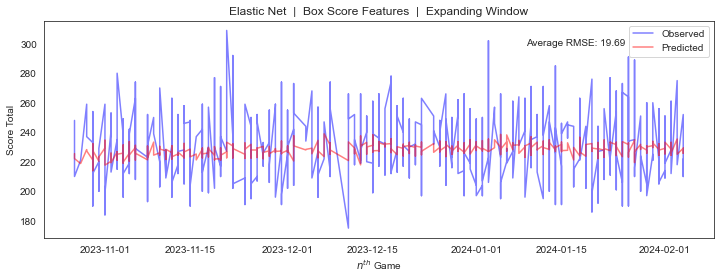

In [11]:
utl.plot_model_performance(
    title='Elastic Net  |  Box Score Features  |  Expanding Window',
    y_label='Score Total',
    metric=metrics['average_rmse'], 
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    initial_train_size=initial_train_size
)

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Models)

In [12]:
# load the best hyperparameters dictionary back from the file
with open('../../hyperparameters/ELN_pm_best_params_advanced.json', 'r') as json_file:
    best_params = json.load(json_file)

# configuration for points difference with expanding window
model = ElasticNet(**best_params)  # model class
target_col = 'PLUS_MINUS'    # target column name
df = pm_scaled_df          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 1652.83 seconds


In [13]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 14.71
- Null RMSE: 15.32


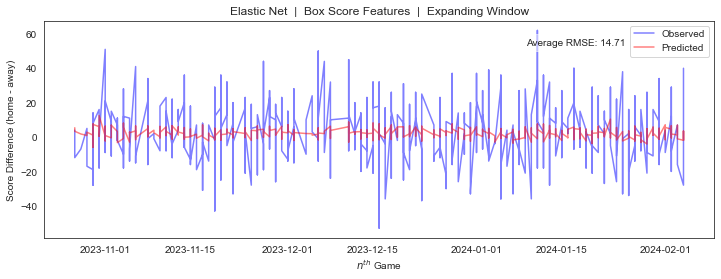

In [14]:
utl.plot_model_performance(
    title='Elastic Net  |  Box Score Features  |  Expanding Window',
    y_label='Score Difference (home - away)',
    metric=metrics['average_rmse'], 
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    initial_train_size=initial_train_size
)

<a name="3.-Target:-Game-Winner-(moneyline)"></a>
# 3. Target: Game Winner (moneyline)

[Return to top](#Models)

In [15]:
# load the best hyperparameters dictionary back from the file
with open('../../hyperparameters/ELN_res_best_params_advanced.json', 'r') as json_file:
    best_params = json.load(json_file)

# configuration for game winner with expanding window
model = LogisticRegression(**best_params)  # model class
target_col = 'GAME_RESULT'    # target column name
df = res_scaled_df          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit,
    ensure_diversity=True # ensure class diversity in training
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 144.64 seconds


In [16]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Classification Metrics:
- Average Accuracy: 0.56
- Overall AUC: 0.49
- Average F1 Score: 0.72


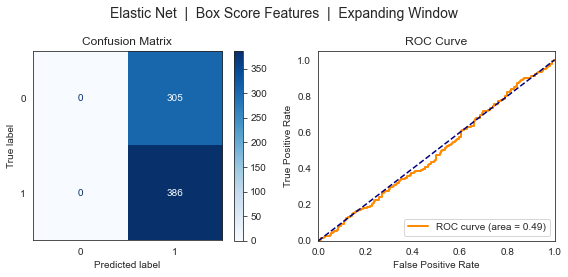

In [17]:
utl.plot_classification_performance(
    y_true=y_true, 
    model_outputs=model_outputs,
    pred_labels=metrics['pred_labels'],
    overall_title='Elastic Net  |  Box Score Features  |  Expanding Window'
)

In [18]:
# write out all model predictions and meta-data
test_set_obs.rename(columns={
    'TOTAL_PTS': 'TOTAL_PTS_PREDS',
    'PLUS_MINUS': 'PLUS_MINUS_PREDS',
    'GAME_RESULT': 'GAME_RESULT_PREDS'
}, inplace=True)
columns_to_round = ['TOTAL_PTS_PREDS', 'PLUS_MINUS_PREDS', 'GAME_RESULT_PREDS']
test_set_obs[columns_to_round] = test_set_obs[columns_to_round].round(4)
test_set_obs.to_csv('../../data/model_predictions/ElasticNet_preds_advanced_stats.csv', index=False)